In [1]:
%matplotlib inline
from sensor_data_analysis_api import *
from sklearn.metrics import mean_squared_error
import sys
import os

In [2]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

blockPrint()

In [3]:
room = 'Rm-4226'
signals = ['Zone Temperature']
method = 'piecewise_constant'

df_4226_zt = get_signal_dataframe(room, signals, mean_type=None, use_weather_data=False)
df_4226_all = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)

### Calculate the root mean squared error and compression ratio for piecewise linear and piece constant

**Compression calculation for piecewise linear and piecewise constant**

- original_size = Filter the data frame for specific week and find the **memory usage** of the data frame (DataFrame.memory_usage())
- compressed_size = Calculate the compressed size with **memory_usage()** on compressed DataFrame
- compression_ratio is calculated as
$$
compression\_ratio = \frac{(original\_size - compressed\_size)}{original\_size}
$$
- Good compression has compression_ratio close to 1.


In [4]:
stTime = pd.to_datetime('2014-01-01')
enTime = stTime + pd.to_timedelta("7 days")
df_list = []
for signal in signals:
    while enTime <= pd.to_datetime('2015-12-31'):
        
        print "********* ", enTime, "********* "

        # piece wise linear
        method = 'piecewise_linear'
        [dfs, plotTemplates, dfs_compressed] = runAnalysis(df_4226_zt, stTime, enTime, templates = [signal], method = method)
        rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
        d = {
             'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
             'original_size' : dfs[0].memory_usage().sum() - dfs[0].memory_usage()['Index'],
             'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
            }
        df_list.append(pd.DataFrame(d, index=[0]))

        # piecewise constant
        method = 'piecewise_constant'
        [dfs, plotTemplates, dfs_compressed] = runAnalysis(df_4226_zt, stTime, enTime, templates = [signal], method = method)
        rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
        d = {
             'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
             'original_size' : dfs[0].memory_usage().sum() - dfs[0].memory_usage()['Index'],
             'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
            }
        df_list.append(pd.DataFrame(d, index=[0]))

        # run length encoding
        method = "run_length_encoding"
        [dfs1, plotTemplates, dfs_compressed] = run_length_encoding(df_4226_zt[['time',  'Zone Temperature']],
                   stTime=stTime, enTime=enTime,
                   tolerance = [pd.to_timedelta("15 minutes"), 1])
        rmse = mean_squared_error(dfs1[0]['values'][dfs1[1].notnull()], dfs1[1][dfs1[1].notnull()])
        d = {
             'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
             'original_size' : dfs1[0].memory_usage().sum() - dfs1[0].memory_usage()['Index'],
             'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
            }
        df_list.append(pd.DataFrame(d, index=[0]))

        # increase by 1 week
        stTime = stTime + pd.to_timedelta("7 days")
        enTime = stTime + pd.to_timedelta("7 days")

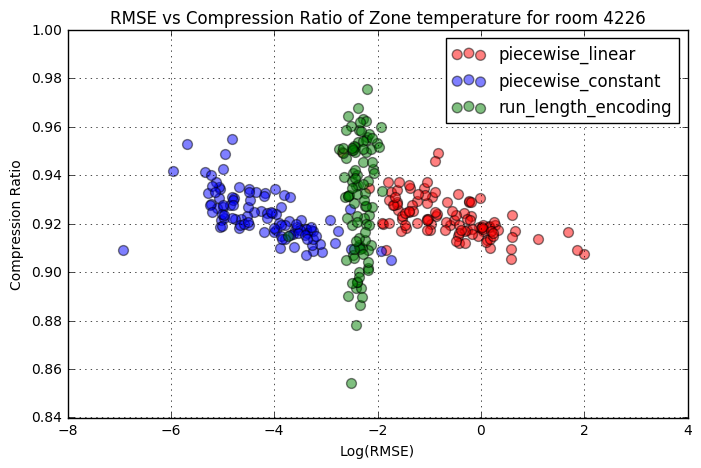

In [5]:
df_result = pd.concat(df_list, ignore_index=True)
df_result['compression_ratio'] = (df_result.original_size - df_result.compressed_size) / df_result.original_size
df_result['rmse_log'] = np.log2(df_result.rmse)
df_result = df_result[df_result.compression_ratio > 0.85]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x = df_result[df_result.model == 'piecewise_linear'].rmse_log,
          y = df_result[df_result.model == 'piecewise_linear'].compression_ratio,
          c = 'red', s=50,
          label='piecewise_linear', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'piecewise_constant'].rmse_log,
          y = df_result[df_result.model == 'piecewise_constant'].compression_ratio,
          c = 'blue', s=50,
          label='piecewise_constant', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'run_length_encoding'].rmse_log,
          y = df_result[df_result.model == 'run_length_encoding'].compression_ratio,
          c = 'green', s=50,
          label='run_length_encoding', alpha=0.5);
ax.legend(loc='best')
ax.grid(True)
ax.set_xlabel("Log(RMSE)")
ax.set_ylabel("Compression Ratio")
ax.set_title("RMSE vs Compression Ratio of Zone temperature for room 4226");

### Compression and encoding with PCA

**encoding and compression**

- All the signals for all the dates for a given room are taken.
- Foreach signal, values are averages for every 15 minute interval. (This is needed because the signals are not recorded exactly at the same time for all signals). so we have to average them for every 15 minutes to bring them to a common scale.
- This is the original data frame and its size is calculated using **memory_usage** function
- PCA is performed on this dataframe and only top n components are choosen
- **compressed_size** if the size of the transformed data with top n components.
- compression_ratio is calculated as
$$
compression\_ratio = \frac{(original\_size - compressed\_size)}{original\_size}
$$
- Good compression has compression_ratio close to 1.
- For PCA the compression ratio do not depend on dates and signal type because complete dataframe with all signals and all dates are used for transformation.
- For PCA compression ratio only depends on number of components chosen.

**Observations**

- For Zone Temerature original signal and the reconstructed signal are very close from 9 components.
- This is observed from graph and also RMSE.

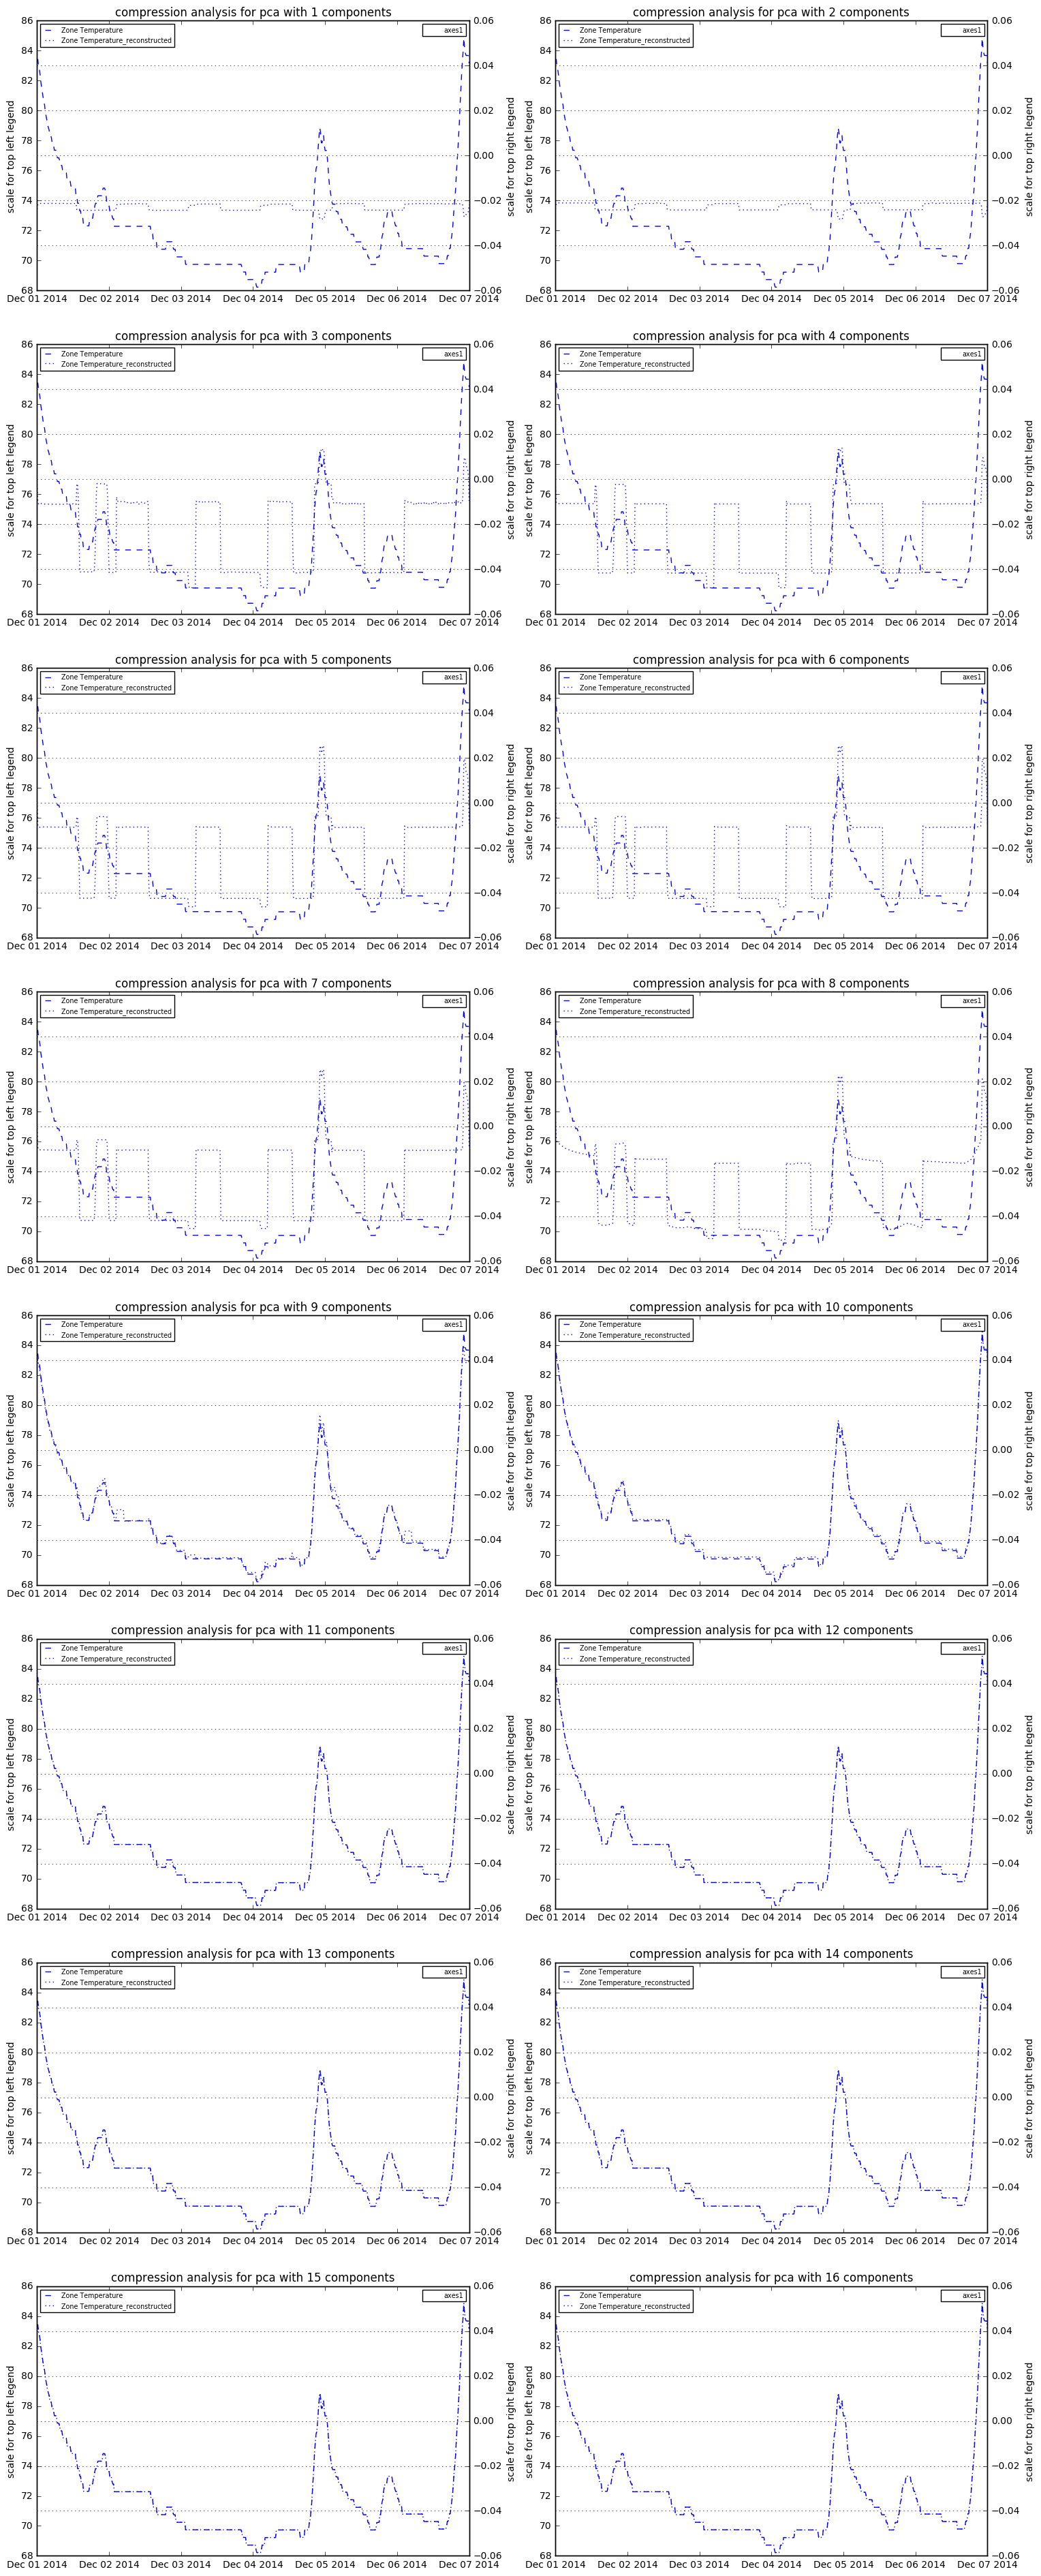

In [6]:
fig, axs = plt.subplots(8, 2, figsize=(18, 48))
axes = axs.flatten()
for n_components in range(1,17): 
    [dfs, plotTemplates, compressed] = CompressWithPCA(df_4226_all, stTime='2014-12-01', enTime='2014-12-07', n_components = n_components)
    plotResults(dfs, plotTemplates, method='pca with %d components'%n_components, ax=axes[n_components - 1])

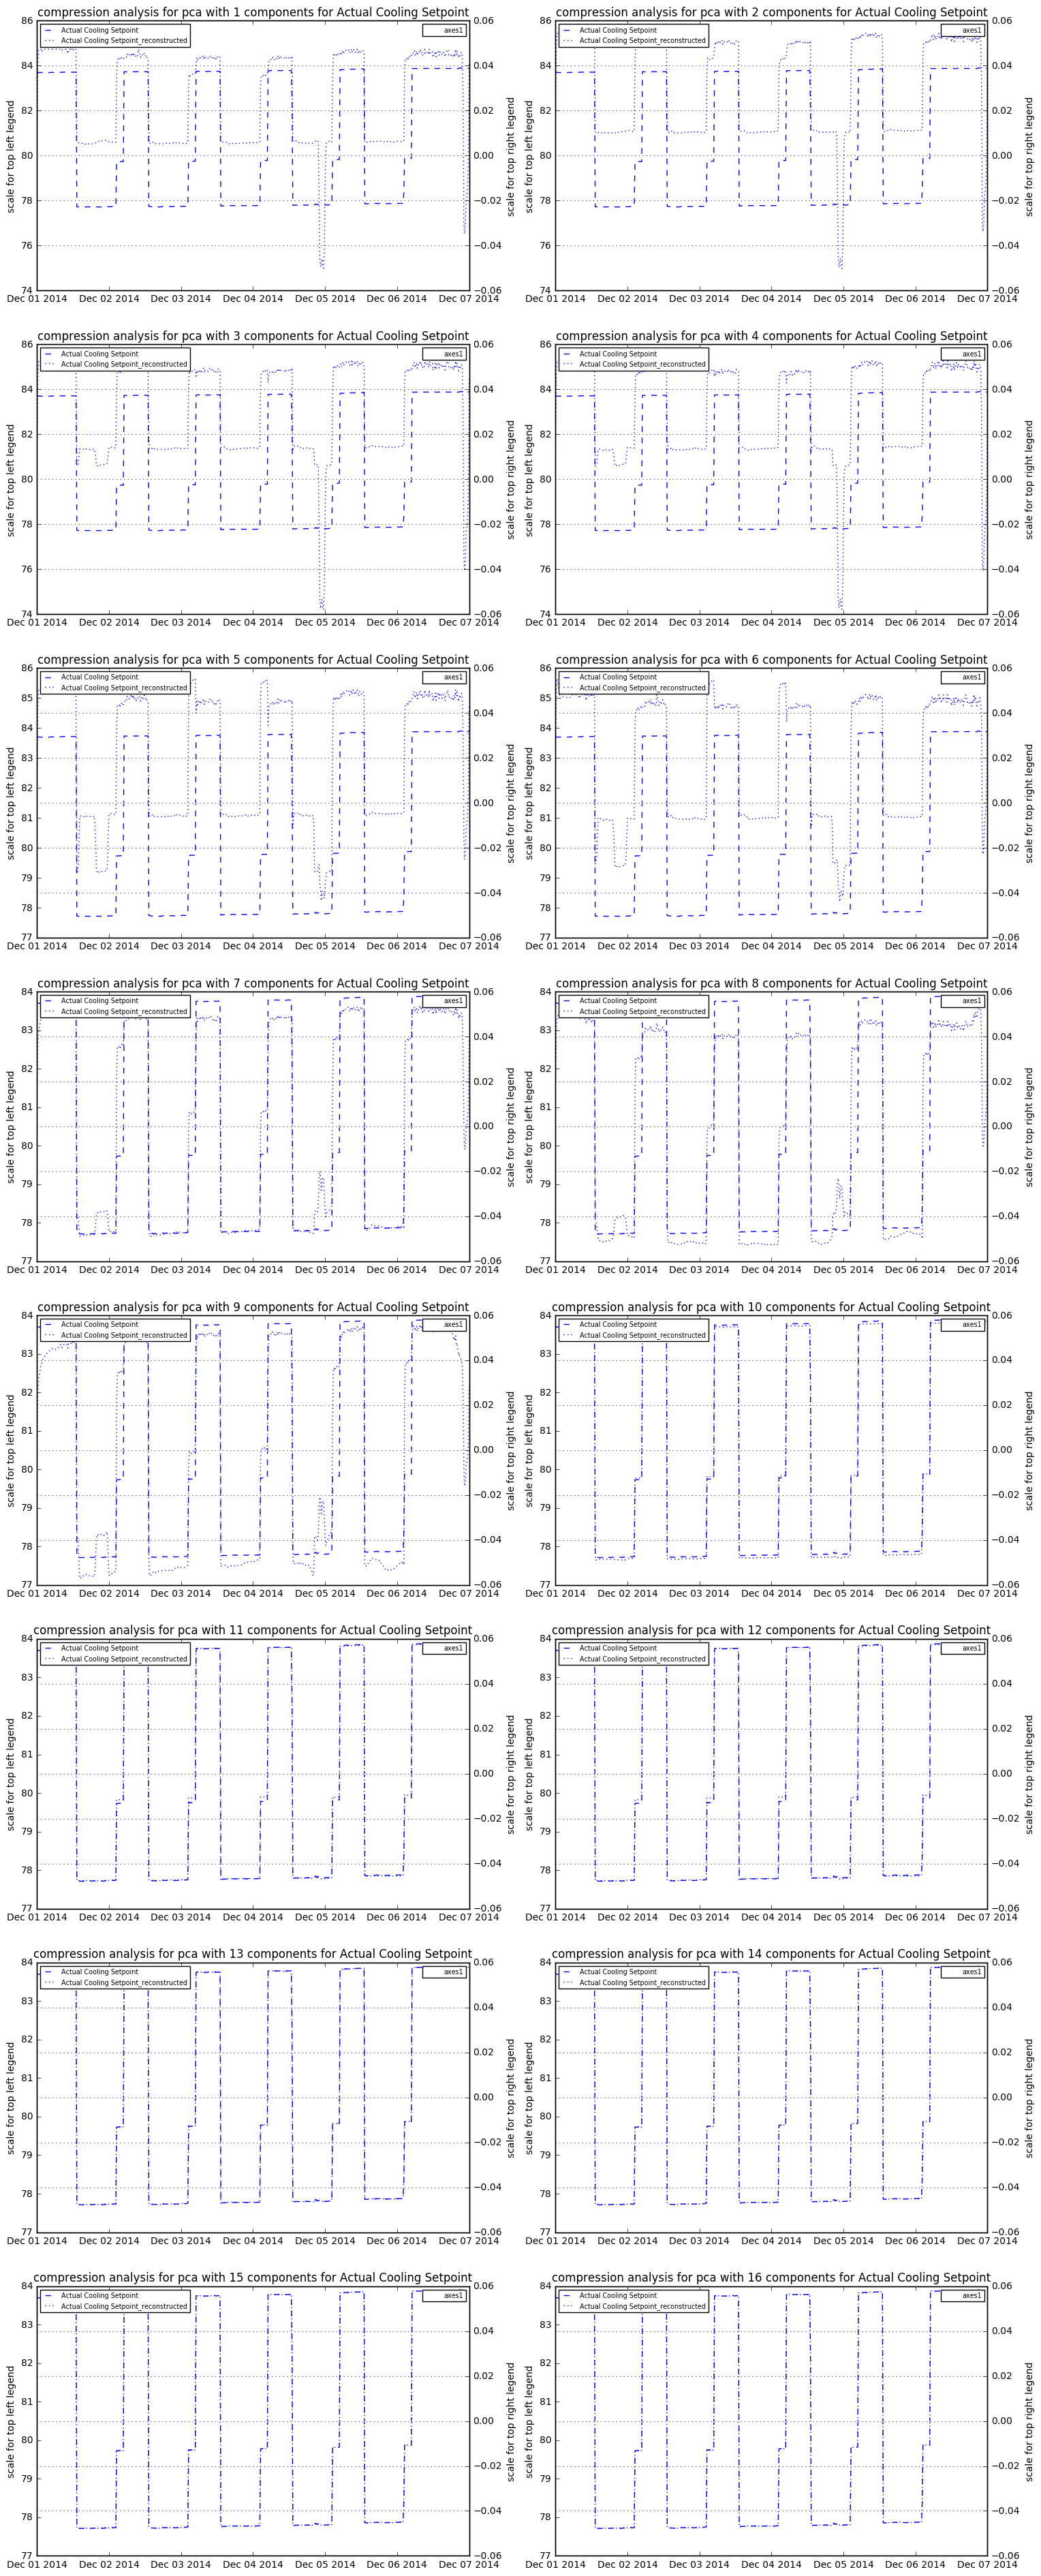

In [11]:
fig, axs = plt.subplots(8, 2, figsize=(18, 48))
axes = axs.flatten()
for n_components in range(1,17): 
    [dfs, plotTemplates, compressed] = CompressWithPCA(
        df_4226_all, stTime='2014-12-01', enTime='2014-12-07', template = 'Actual Cooling Setpoint',
        n_components = n_components)
    plotResults(dfs, plotTemplates, method='pca with %d components for Actual Cooling Setpoint'%n_components,
                ax=axes[n_components - 1])

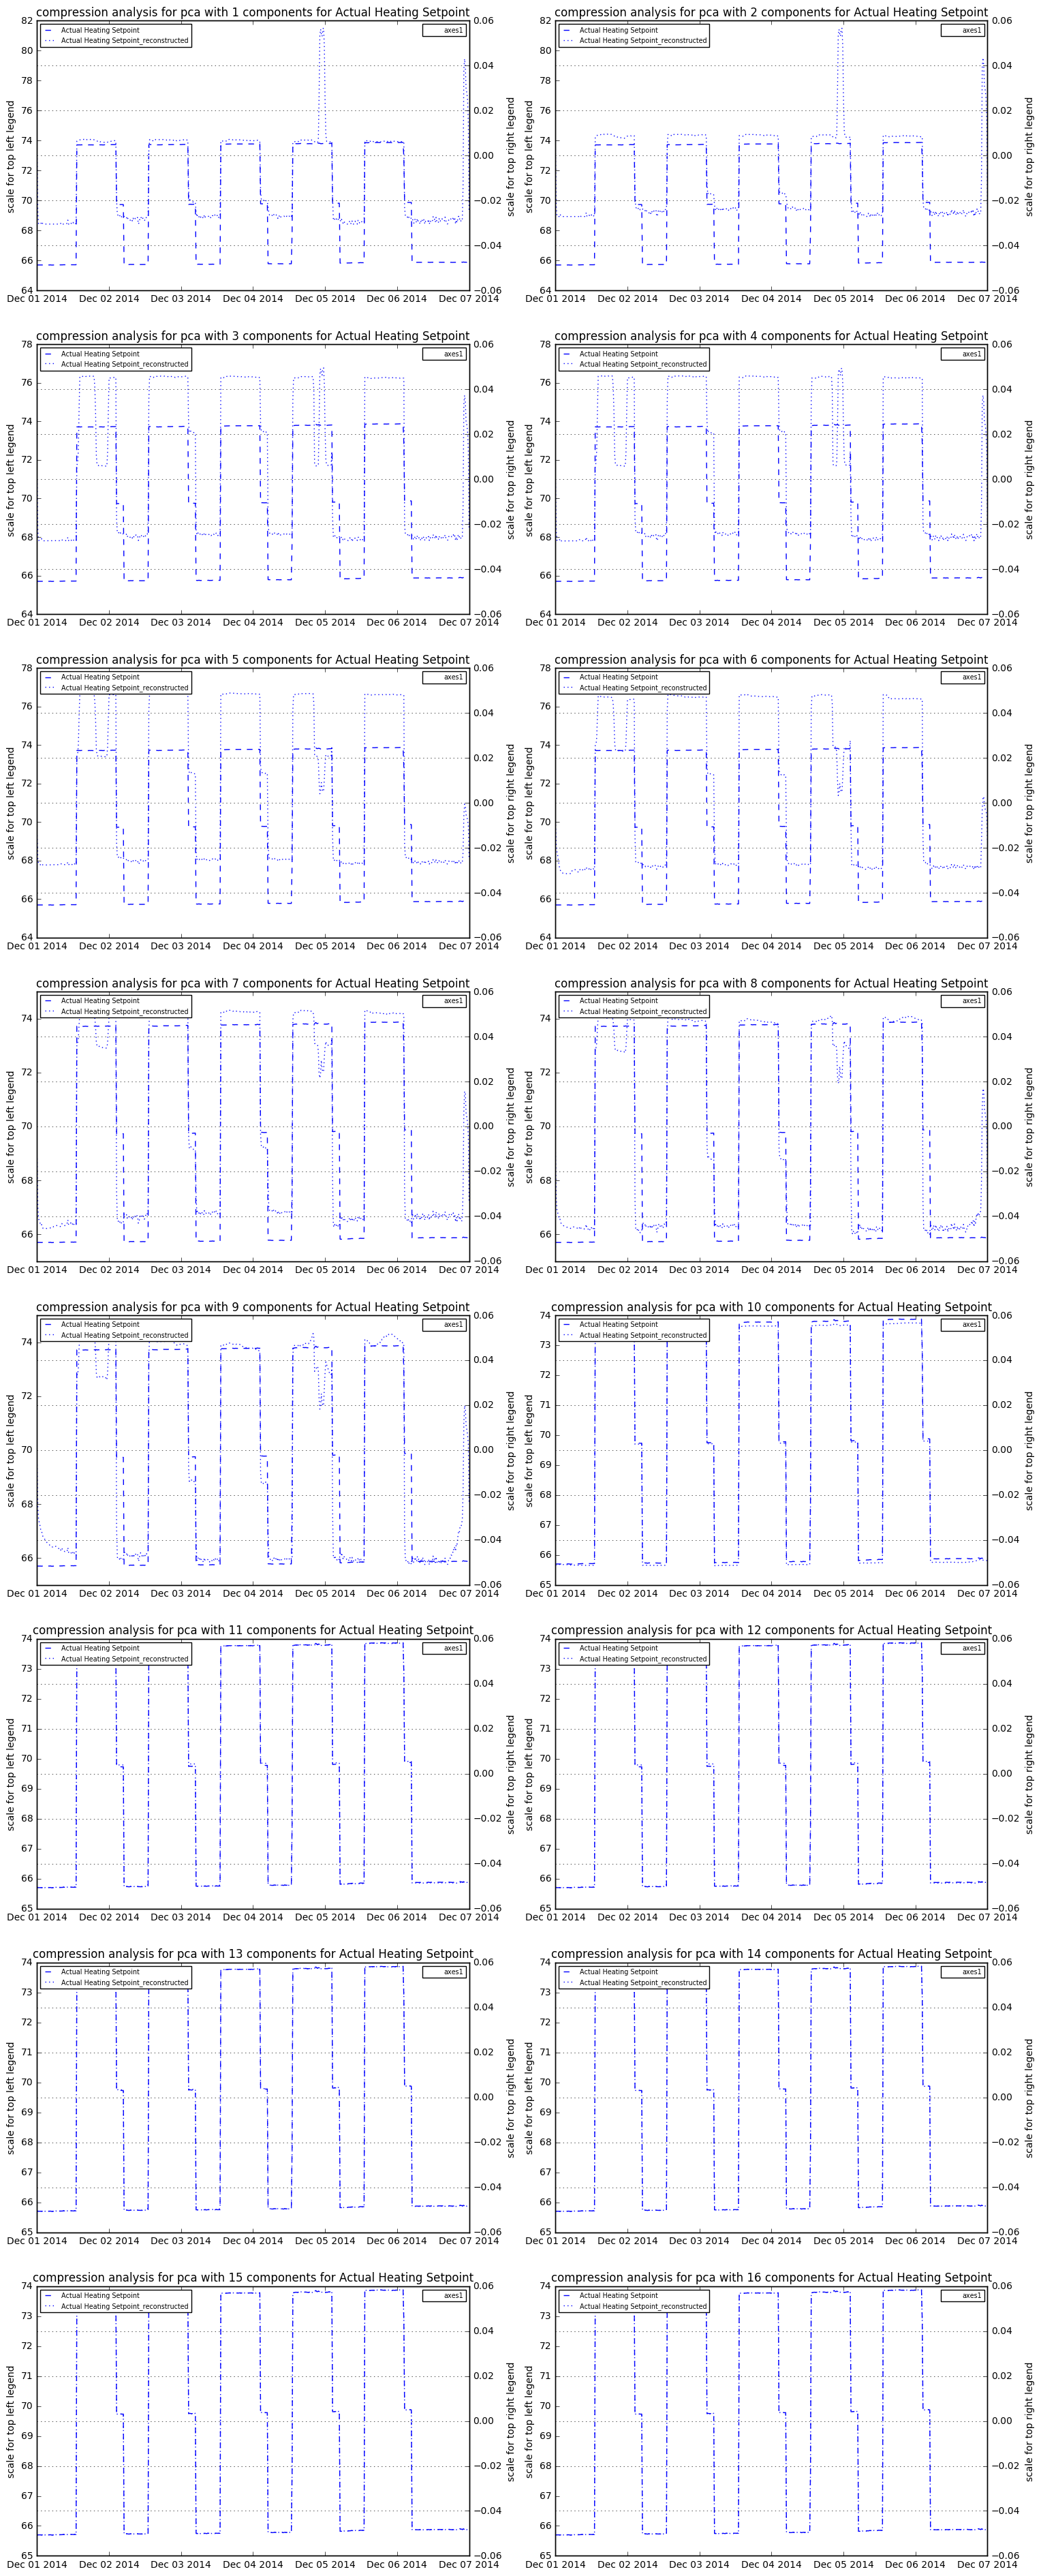

In [12]:
fig, axs = plt.subplots(8, 2, figsize=(18, 48))
axes = axs.flatten()
for n_components in range(1,17): 
    [dfs, plotTemplates, compressed] = CompressWithPCA(
        df_4226_all, stTime='2014-12-01', enTime='2014-12-07', template = 'Actual Heating Setpoint',
        n_components = n_components)
    plotResults(dfs, plotTemplates, method='pca with %d components for Actual Heating Setpoint'%n_components,
                ax=axes[n_components - 1])

In [9]:
df_4226_all.head(1)

Ground Truth Point Type,time,location,Actual Cooling Setpoint,Actual Heating Setpoint,Cooling Command,Damper Command,Damper Position,Heating Command,Maximum Supply Airflow,Minimum Occupied Cooling Supply Airflow,Minimum Occupied Heating Supply Airflow,Occupancy Command,Reheat Valve Command,Supply Airflow,Supply Airflow Setpoint,Temperature Setpoint,Warm Cool Adjust,Zone Temperature
0,2014-01-01,Rm-4226,82.43,64.4225,35.8275,0.16,23.1225,0.0,1000.0,800.0,100.0,1.0,0.0,377.2875,387.4275,71.0,3.43,82.37


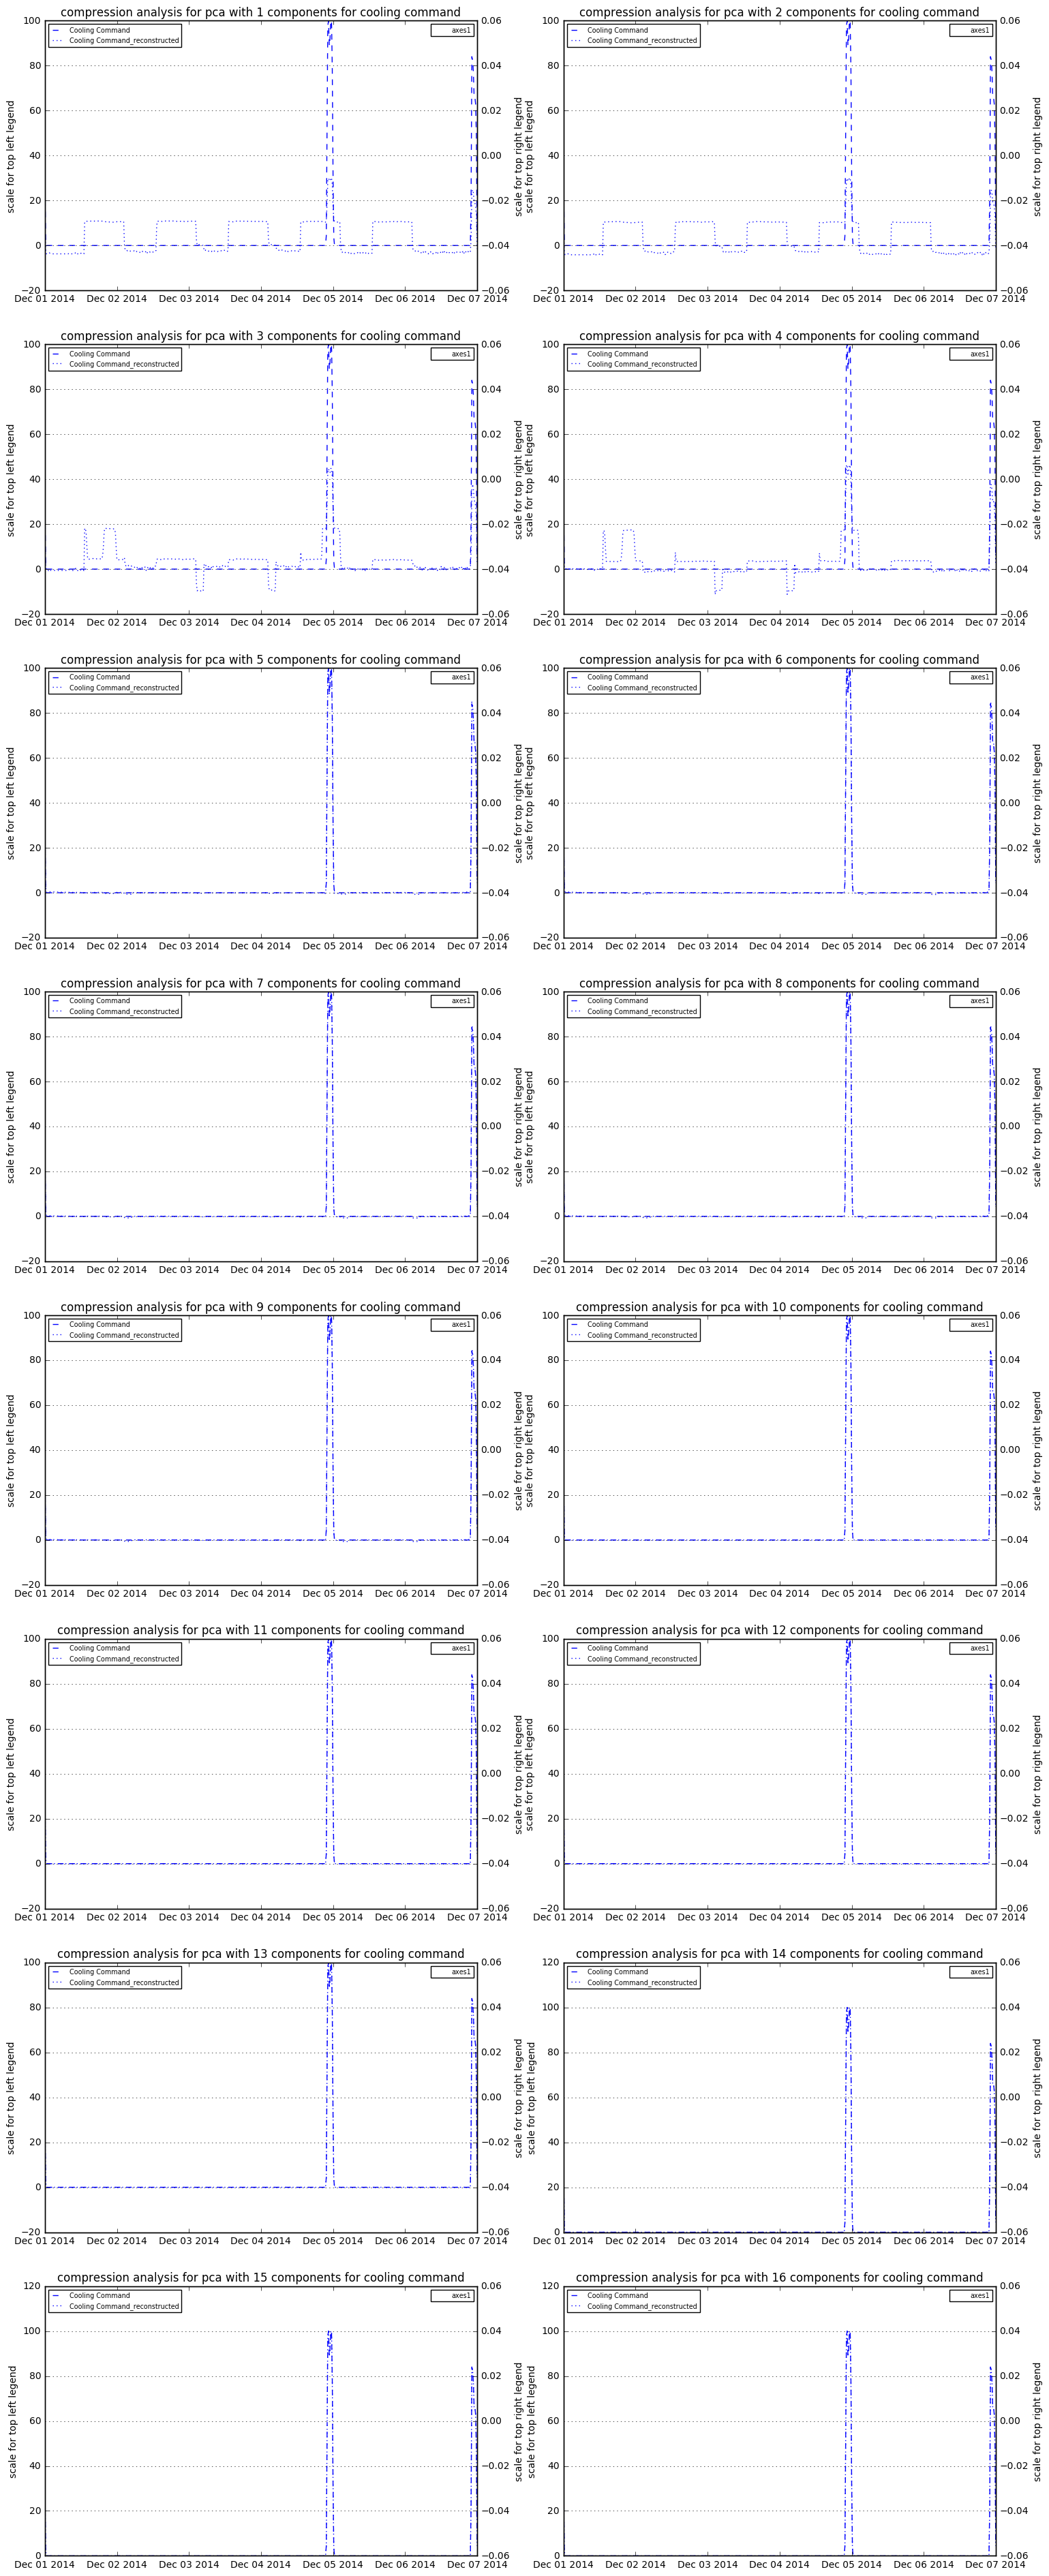

In [13]:
fig, axs = plt.subplots(8, 2, figsize=(18, 48))
axes = axs.flatten()
for n_components in range(1,17): 
    [dfs, plotTemplates, compressed] = CompressWithPCA(
        df_4226_all, stTime='2014-12-01', enTime='2014-12-07', template = 'Cooling Command',
        n_components = n_components)
    plotResults(dfs, plotTemplates, method='pca with %d components for cooling command'%n_components,
                ax=axes[n_components - 1])